# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brearenee/NLP-Project/blob/main/startrek.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/https://github.com/brearenee/NLP-Project/blob/main/startrek.ipynb)


## 1. Introduction/Background
In this notebook, I'll be working with a dataset containing dialogue transcripts from various Star Trek series episodes, which I found on [kaggle](http://http://https://www.kaggle.com/datasets/birkoruzicka/startrekdialoguetranscripts/data). This dataset provides a large amount of script lines, each accompanied by information on episode, series, and the character who delivered said line. 

The objective of this project is to build a model capable of predicting the character(y value) associated with a given line(x value) from the script from the series "The Next Generation".  This type of problem is known as Authorship attribution which is a more specific task of the text classification problem since model will need to learn patterns that are indicative of the speaking style of each character. 

These types of analysis can be difficult, but since the characters on Star Trek have such distinct personalities and speaking styles, I'm curious to see how well it can do. 

There are multiple different characters in Star Trek TNG, meaning the model's prediction ( y value) is one of many, resulting in a multi-classification type task. To simplify the model, I'll be narrowing the output down to the top 8 characters in the show. 




## 2. Data Preprocessing/ Exploratory Data Analysis

This part of the process involves looking at the data, and making adjustments as needed to clean the dataset and ensure its in a suitable format for analysis.  This creates a Exploratory Data Analysis to Data Preprocessing cycle. 


To start, the datasource I'm working with is initially structured as a highly nested JSON file, and it's original format isn't quite optimal for the model I'm trying to create. 
You can peek at the original JSON file [here](http://https://raw.githubusercontent.com/brearenee/NLP-Project/main/dataset/StarTrekDialogue_v2.json) (it's too large to load in this notebook)

It also includes a lot of data I don't necessarily need. Becase of this, I'll need to parse through the file and transform it's structure to allow for a more useful dataframe. As I'm only trying to predict lines from "The Next Generation", I'll also be removing the other series from my dataset. 



In [1]:
import pandas as pd
import json
import requests
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
url = 'https://raw.githubusercontent.com/brearenee/NLP-Project/main/dataset/StarTrekDialogue_v2.json'
response = requests.get(url)

##This CodeBlock is thanks to ChatGPT :-) 
if response.status_code == 200:
    json_data = json.loads(response.text)
    lines = []
    characters = []
    episodes = []
  
    # extract the information from the JSON file for the "TNG" series
    for series_name, series_data in json_data.items():
        if series_name == "TNG": 
            for episode_name, episode_data in series_data.items():
                for character_name, character_lines in episode_data.items():
                    for line_text in character_lines:
                        lines.append(line_text)
                        characters.append(character_name)
                        episodes.append(episode_name)
                     
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'Line': lines,
        'Character': characters,
        'Episode': episodes,
    })

    # Remove duplicate lines, keeping the first occurrence (preserving the original order)
    df = df.drop_duplicates(subset='Line', keep='first')

    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Now that our JSON file is parsed, lets take a look at our dataframe. 

In [3]:
df.head(100)

,Line,Character,Episode
0,"You will agree, Data, that Starfleet's\r order...",PICARD,tng_000
1,As simple as that.,PICARD,tng_000
2,"It's hardly simple, Data, to negotiate a frien...",PICARD,tng_000
3,"Data, how can you be programmed as a virtual e...",PICARD,tng_000
4,"It means to spy, to sneak.",PICARD,tng_000
...,...,...,...
95,My crew and I need a bit more information\r be...,PICARD,tng_000
96,"Good, since we admire what we've seen of your ...",PICARD,tng_000
97,Counsellor? What is it?,PICARD,tng_000
98,Yes. No secrets here if we're to be all to be ...,PICARD,tng_000


lets explore the Characters field to see what Characters exist in our dataframe. 

In [4]:
unique_characters = df['Character'].unique().tolist()

# Display the list of unique characters
print(unique_characters)

['PICARD', 'DATA', 'TROI', 'TORRES', 'WORF', 'Q', 'TASHA', "O'BRIEN", 'BAILIFF', 'SOLDIER', 'ZORN', 'RIKER', 'WESLEY', 'CRUSHER', 'LAFORGE', 'MCCOY', 'ENSIGN', 'COMPUTER', 'SECURITY', 'CREW', 'WOMAN', 'MAN', 'SHIMODA', 'MACDOUGAL', 'CREWMAN', 'LUTAN', 'HAGON', 'YAREENA', 'CHIEF', 'TARR', 'LETEK', 'MORDOC', 'KAYRON', 'PORTAL', 'KOSINSKI', 'ARGYLE', 'TRAVELLER', 'MAMAN', 'SELAY', 'GEORDI', 'ANTICAN', 'SINGH', 'RIVAN', 'LIATOR', 'EDO', 'BOY', 'GIRL', 'OFFICER', 'MEDIATOR 2', 'MEDIATOR', 'BEVERLY', 'MEDIC', 'BOK', 'KAZAGO', 'RATA', 'VOICES', 'VOICE', 'FACE', 'STEVEN', 'VICTORIA', 'WYATT', 'LWAXANA', 'VALEDA', 'WRENN', 'ARIANA', 'HOMN', 'SECRETARY', 'JESSICA', 'LEECH', 'WHALEN', 'VENDOR', 'BELL', 'MCNARY', 'JARADAN', 'POLICEMAN', 'SERGEANT', 'REDBLOCK', 'THUG', 'LORE', 'BEATA', 'ARIEL', 'TRENT', 'RAMSEY', 'QUINTEROS', 'ONE ZERO', 'ZERO ONE', 'ZERO ZERO', 'ONE ONE', 'MINUET', 'BASS', 'PIANO', 'STARBASE', 'JAMESON', 'KARNAS', 'ANNE', 'BERNARD', 'HARRY', 'RASHELLA', 'RADUE', 'KATIE', 'TOYA', '

As you can see, this is pretty messy, as this series has quite a few one-off characters. Let's eliminate all of the outliers by removing characters that don't occur in more than 5 episodes. 

In [5]:
episode_counts = df.groupby('Character')['Episode'].nunique()

characters_to_keep = episode_counts[episode_counts > 5].index

df = df[df['Character'].isin(characters_to_keep)]
unique_characters = df['Character'].unique().tolist()


print(unique_characters)

['PICARD', 'DATA', 'TROI', 'WORF', 'Q', 'TASHA', "O'BRIEN", 'RIKER', 'WESLEY', 'CRUSHER', 'LAFORGE', 'COMPUTER', 'SECURITY', 'WOMAN', 'MAN', 'CREWMAN', 'CHIEF', 'MEDIC', 'VOICE', 'LWAXANA', 'CREWWOMAN', 'NURSE', 'GUINAN', 'PULASKI', 'ALL', 'OGAWA', 'KLINGON', 'ROMULAN', 'ALEXANDER', 'KEIKO', 'RO']


This result is a lot better, but there are still some fields in here like "ALL" "BOTH" or "GIRL" that dont correlate to one single character/species 

lets check the character distribution


In [6]:
df['Character'].value_counts()


Character
PICARD       10798
RIKER         6454
DATA          5699
LAFORGE       4111
WORF          3185
CRUSHER       2944
TROI          2856
WESLEY        1206
Q              535
PULASKI        487
TASHA          474
COMPUTER       471
O'BRIEN        440
GUINAN         432
LWAXANA        404
RO             304
ALEXANDER      156
OGAWA          110
KEIKO           78
CREWMAN         51
WOMAN           46
NURSE           30
CHIEF           28
VOICE           27
ROMULAN         25
MAN             22
CREWWOMAN       17
SECURITY        15
KLINGON         14
ALL             13
MEDIC            6
Name: count, dtype: int64

This shows how many lines each character has in our dataset.  Since this distribution is so uneven, lets once again remove the outliers.  

We will do this by eliminating those characters with less than 1000 lines. 

In [7]:
character_counts = df['Character'].value_counts()

characters_to_remove = character_counts[character_counts < 1000].index
df = df[~df['Character'].isin(characters_to_remove)]


and lets once again take a look at our Character distribution now that we have removed the outliers

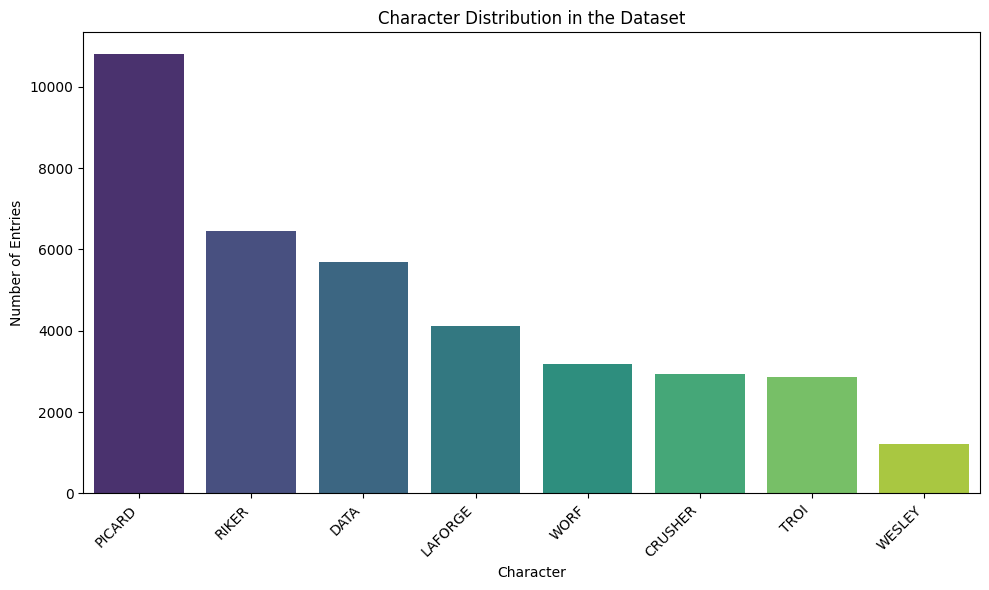

In [8]:
character_counts = df['Character'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=character_counts.index, y=character_counts.values, palette="viridis")
plt.xlabel('Character')
plt.ylabel('Number of Entries')
plt.title('Character Distribution in the Dataset')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [9]:
print(character_counts)

Character
PICARD     10798
RIKER       6454
DATA        5699
LAFORGE     4111
WORF        3185
CRUSHER     2944
TROI        2856
WESLEY      1206
Name: count, dtype: int64


## Tokenizing 
Before we explore our Observations/Lines, lets tokenize the "Lines" field in our dataframe.  This breaks each sentence down into various tokens so the model can interpret them better. 

For now I'm going to leave stop words in, because theres a chance they might have some stylistic nuances that help predicit the character. 
But because this dataset is scraped from the internet, I'm going to lowercase all of the text in the Line field to keep consistencies. 

In [10]:
nltk.download('punkt')
df['Line'] = df['Line'].apply(lambda x: word_tokenize(x.lower()))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Lets print out the words/tokens that show up most. 

In [11]:
# Assuming 'df' is your DataFrame with a column 'Tokenized_Lines'
# Make sure you have the necessary libraries and data loaded

# Flatten the list of lists to a single list of tokens
all_tokens = [token for sublist in df['Line'] for token in sublist]

# Create a DataFrame with word frequencies
word_frequencies = pd.DataFrame({
    'Word': all_tokens
})

# Get the top 5 words
top_words = word_frequencies['Word'].value_counts().head(20)

# Display the top 5 words
print("Top 5 words:")
print(top_words)


Top 5 words:
Word
.       52781
,       25925
the     19638
to      15146
i       14973
you     12713
?        9671
a        9294
it       8228
of       7937
is       7069
that     6707
we       6562
's       6159
and      5186
in       4767
have     4663
this     3921
be       3784
do       3759
Name: count, dtype: int64


As we can see, there's a lot of punctuation. But there's a chance that commas and question marks might help predict a Character due to style of speaking, so these punctuation styles will stay in for now. 

What's the vocabulary size? 

In [12]:
vocabulary_size = len(set(word for tokens in df['Line'] for word in tokens))

print("Vocabulary Size:", vocabulary_size)

Vocabulary Size: 16123


Lets add a "Line Length" to a our dataframe, and print out a chart showing average line length per character. 

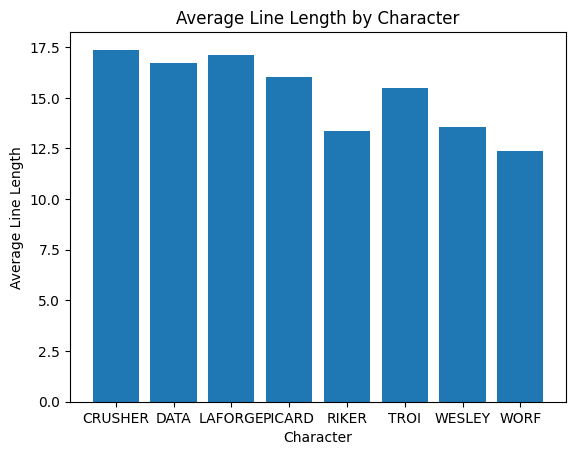

In [13]:

df['Line Length'] = df['Line'].apply(len)
avg_line_length_by_character = df.groupby('Character')['Line Length'].mean().reset_index()


plt.bar(avg_line_length_by_character['Character'], avg_line_length_by_character['Line Length'])
plt.xlabel('Character')
plt.ylabel('Average Line Length')
plt.title('Average Line Length by Character')
plt.show()

I was surprised to see that overall, the average line length is consistent across the board.  Lets look at distribution of line length in general, where length is the number of tokens in a line. 

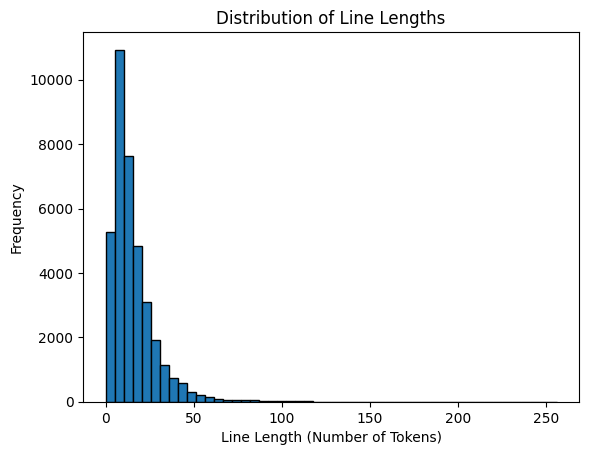

In [14]:
plt.hist(df['Line Length'], bins=50, edgecolor='black')
plt.xlabel('Line Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Line Lengths')
plt.show()

For the most part, the length of each line is around 20 tokens. But lets see the outliers, whos responsible for giving speeches in this show. 

Lets filter by lines over 200 tokens

In [15]:
long_lines_df = df[df['Line Length'] > 175]

long_lines_df[['Character','Line Length']]

,Character,Line Length
12012,PICARD,236
27648,WESLEY,184
31991,CRUSHER,256
55976,PICARD,201


Looks like Picard is the most common one giving speeches, but Dr Crusher and her sone Wesley also give a speech. 

One last look at our dataframe with the tokenized lines and Line Length

In [16]:
df.head(10)

,Line,Character,Episode,Line Length
0,"[you, will, agree, ,, data, ,, that, starfleet...",PICARD,tng_000,12
1,"[as, simple, as, that, .]",PICARD,tng_000,5
2,"[it, 's, hardly, simple, ,, data, ,, to, negot...",PICARD,tng_000,36
3,"[data, ,, how, can, you, be, programmed, as, a...",PICARD,tng_000,22
4,"[it, means, to, spy, ,, to, sneak, .]",PICARD,tng_000,8
5,"[exactly, ,, yes, .]",PICARD,tng_000,4
6,"[shut, off, that, damned, noise, ., go, to, ye...",PICARD,tng_000,11
7,"[reverse, power, ,, full, stop, .]",PICARD,tng_000,6
8,"[that, 's, quite, a, directive, ., would, you,...",PICARD,tng_000,14
9,"[data, ,, call, medics, .]",PICARD,tng_000,5
